In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import json

In [2]:
curr_dir=os.getcwd()
grandparent_dir = os.path.abspath(os.path.join(curr_dir, os.pardir,os.pardir))
print(grandparent_dir)
sys.path.append(os.path.join(grandparent_dir))
sys.path.append(os.path.join(grandparent_dir, 'liset_tk'))
print(sys.path)

from liset_aux import ripples_std, middle


c:\Users\NCN\Documents\PedroFelix\LAVA_SNN_ripples
['c:\\nrn\\lib\\python', 'c:\\Users\\NCN\\Miniconda3\\envs\\lava_snn_ripples\\python39.zip', 'c:\\Users\\NCN\\Miniconda3\\envs\\lava_snn_ripples\\DLLs', 'c:\\Users\\NCN\\Miniconda3\\envs\\lava_snn_ripples\\lib', 'c:\\Users\\NCN\\Miniconda3\\envs\\lava_snn_ripples', '', 'c:\\Users\\NCN\\Miniconda3\\envs\\lava_snn_ripples\\lib\\site-packages', 'c:\\Users\\NCN\\Miniconda3\\envs\\lava_snn_ripples\\lib\\site-packages\\win32', 'c:\\Users\\NCN\\Miniconda3\\envs\\lava_snn_ripples\\lib\\site-packages\\win32\\lib', 'c:\\Users\\NCN\\Miniconda3\\envs\\lava_snn_ripples\\lib\\site-packages\\Pythonwin', 'c:\\Users\\NCN\\Documents\\PedroFelix\\LAVA_SNN_ripples', 'c:\\Users\\NCN\\Documents\\PedroFelix\\LAVA_SNN_ripples\\liset_tk']


In [3]:
# parent = r"C:\__NeuroSpark_Liset_Dataset__\neurospark_mat\CNN_TRAINING_SESSIONS" # Modify this to your data path folder
parent = r"C:\__NeuroSpark_Liset_Dataset__\neurospark_mat\Download_from_paper" # Modify this to your data path folder
# parent=r"E:\neurospark_mat\CNN_TRAINING_SESSIONS"
# parent=r"E:\neurospark_mat\Download_from_paper"

bandpass=[100,250]
downsampled_fs =1000 # Downsampled frequency
factor=downsampled_fs//1000
time_max=120
window_size=0.200
sample_ratio=0.25
scaling_factor=1
refractory=0
percentile=False
fraction=0.8

In [4]:
dt=1  # Time step in milliseconds (1 ms)


RIPPLE_DETECTION_OFFSET = [18, 45, 31, 20] # it's calculated as 4.5 periods of the ripple wavelet - for 100 Hz and 250 Hz as the limit frequencies
# The Windows for HFO detection are based on the MAX DETECTION OFFSET

#TODO - Why are these values? Can I tune them in a better way?
RIPPLE_CONFIDENCE_WINDOW = int(round(RIPPLE_DETECTION_OFFSET[1] * 1.8)) 

# in timesteps (ms) - Max time from the Insertion Timing to the GT annotation
MAX_DETECTION_OFFSET = RIPPLE_DETECTION_OFFSET[1]   # in timesteps (ms)

MEAN_DETECTION_OFFSET = RIPPLE_DETECTION_OFFSET[2]   # in timesteps (ms)

WINDOW_SIZE = int(RIPPLE_DETECTION_OFFSET[1]*4)   # in timesteps (ms) - The size of the window to slice the input data

# unit: timesteps (ms) - The number of steps that 2 consecutive windows must overlap to not lose any relevant CBs

# std, mean = ripples_std(parent) # 61 ms # in seconds
# INTERSECT_WINDOW_LEN=int((std+mean)*1000) # in timesteps (ms) - The size of the intersection window to slice the input data
INTERSECT_WINDOW_LEN=60 # in timesteps (ms) - The size of the intersection window to slice the input data

# unit: timesteps (ms) - The number of steps that the window must shift to get the next window
WINDOW_SHIFT = int(WINDOW_SIZE - INTERSECT_WINDOW_LEN)

# unit: timesteps (ms) - The time window after the GT annotation where the network should predict the burst (GT_time, GT_time + PRED_CAUSALITY_WINDOW)
# This is needed to give the network some extra time steps to increase the membrane potential and spike
PRED_CAUSALITY_WINDOW = int(5)     # Giving PRED_CAUSALITY_WINDOW ms for the network to update its inner state and spike   

# unit: timesteps (ms) - The time window around the GT annotation where the network should predict the burst (GT_time - PRED_GT_TOLERANCE, GT_time + PRED_GT_TOLERANCE)
PRED_GT_TOLERANCE = int(RIPPLE_DETECTION_OFFSET[3])  # in timesteps (ms)
print(f"WINDOW_SIZE: {WINDOW_SIZE}")
print(f"INTERSECT_WINDOW_LEN: {INTERSECT_WINDOW_LEN} (MEAN+STD)")
print(f"WINDOW_SHIFT: {WINDOW_SHIFT}")
print(f"MEAN DETECTION OFFSET: {MEAN_DETECTION_OFFSET}")
print(f"PRED_GT_TOLERANCE: {PRED_GT_TOLERANCE}")
print(f"PRED_CAUSALITY_WINDOW: {PRED_CAUSALITY_WINDOW}")

WINDOW_SIZE: 180
INTERSECT_WINDOW_LEN: 60 (MEAN+STD)
WINDOW_SHIFT: 120
MEAN DETECTION OFFSET: 31
PRED_GT_TOLERANCE: 20
PRED_CAUSALITY_WINDOW: 5


In [5]:
config = {
    "bandpass": bandpass,
    "downsampled_fs": downsampled_fs,
    "time_max": time_max,
    "window_size": window_size,
    "sample_ratio": sample_ratio,
    "scaling_factor": scaling_factor,
    "refractory": refractory,
    "dt":dt,
    "percentile":percentile,
    "WINDOW_SHIFT": WINDOW_SHIFT,
    "WINDOW_SIZE": WINDOW_SIZE,
    "INTERSECT_WINDOW_LEN": INTERSECT_WINDOW_LEN,
    "RIPPLE_DETECTION_OFFSET": RIPPLE_DETECTION_OFFSET,
    "PRED_CAUSALITY_WINDOW": PRED_CAUSALITY_WINDOW,
    "fraction":fraction,
}
print(config)

{'bandpass': [100, 250], 'downsampled_fs': 1000, 'time_max': 120, 'window_size': 0.2, 'sample_ratio': 0.25, 'scaling_factor': 1, 'refractory': 0, 'dt': 1, 'percentile': False, 'WINDOW_SHIFT': 120, 'WINDOW_SIZE': 180, 'INTERSECT_WINDOW_LEN': 60, 'RIPPLE_DETECTION_OFFSET': [18, 45, 31, 20], 'PRED_CAUSALITY_WINDOW': 5, 'fraction': 0.8}


In [6]:
from signal_aid import most_active_channel, bandpass_filter


## Extract Windows
Extract UP/DN spike Windows


In [7]:
load=False

from extract_Nripples.utils_encoding import *
# Only run this block if first time
if 'windowed_input_data' not in locals():
    if load:
        windowed_path=os.path.join(curr_dir,"windowed_data")
        windowed_input_data = np.load(os.path.join(windowed_path,"windowed_input_data.npy"))
        windowed_gt = np.load(os.path.join(windowed_path,"windowed_gt.npy"))
        filtered_windows=np.load(os.path.join(windowed_path,"filtered_windows.npy"))
    else:
        # from make_windows import *
        # windowed_input_data, windowed_gt, filtered_windows, config=make_windows(parent,config,time_max,downsampled_fs,bandpass,window_size,sample_ratio, scaling_factor, 
        #              refractory,WINDOW_SHIFT, WINDOW_SIZE,MEAN_DETECTION_OFFSET,MAX_DETECTION_OFFSET,factor)
        from make_windows2 import *
        windowed_input_data, windowed_gt, filtered_windows,ripple_ids, config=make_windows_mesquita(parent,config,time_max,downsampled_fs,bandpass,window_size,sample_ratio, scaling_factor, 
                     refractory,WINDOW_SHIFT, WINDOW_SIZE,MEAN_DETECTION_OFFSET,MAX_DETECTION_OFFSET,factor,fraction=fraction)
else:
    print("windowed_input_data already loaded")

data shape:  (57572556, 8)
ripples shape:  (1085, 2)
[WARNING] Window [103680:103860] has a GT event at [103735 103786] and NO Input activations. Skipping...
[WARNING] Window [321840:322020] has a GT event at [321792 321841] and NO Input activations. Skipping...
[WARNING] Window [434520:434700] has a GT event at [434485 434523] and NO Input activations. Skipping...
[WARNING] Current window [1918920, 1919100] is smaller than the expected size. Breaking the loop...
[WARNING] Window [103680:103860] has a GT event at [103735 103786] and NO Input activations. Skipping...
[WARNING] Window [369240:369420] has a GT event at [369192 369241] and NO Input activations. Skipping...
[WARNING] Window [434520:434700] has a GT event at [434485 434523] and NO Input activations. Skipping...
[WARNING] Current window [1918920, 1919100] is smaller than the expected size. Breaking the loop...
[WARNING] Window [369240:369420] has a GT event at [369192 369241] and NO Input activations. Skipping...
[WARNING] Wi

In [8]:
up_spikes_per_window = np.sum(windowed_input_data[:, :, 0], axis=1)    # Sum along time axis
down_spikes_per_window = np.sum(windowed_input_data[:, :, 1], axis=1)  # Sum along time axis
print("Up Spikes Total:",np.sum(up_spikes_per_window))
print("Down Spikes Total:",np.sum(down_spikes_per_window))

Up Spikes Total: 890065.0
Down Spikes Total: 899515.0


In [9]:
# See GT Class Distribution
# Set print options to see more elements
np.set_printoptions(linewidth=100, threshold=50, edgeitems=20)
print(f"Ground Truth Class Distribution: {np.unique(windowed_gt, return_counts=True)}")
GT_HFO_MASK = windowed_gt >= 0
# print(windowed_gt[0:1000])
# Define the number of windows with an HFO
num_hfo_windows = np.sum(GT_HFO_MASK)
print(f"Number of windows with an HFO: {num_hfo_windows}")
print(f"Percentage of windows with an HFO: {num_hfo_windows / windowed_gt.shape[0] * 100:.2f}%")


Ground Truth Class Distribution: (array([ -1.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49., ..., 147., 148., 149., 150., 151., 152., 153., 154., 155.,
       156., 157., 158., 159., 160., 161., 162., 163., 164., 165., 166.], dtype=float32), array([162144,    103,    148,    134,    150,    209,    144,    158,    163,    183,    197,
          153,    193,    179,    149,    187,    189,    142,    167,    156, ...,    101,    126,
          102,    130,     83,    115,    104,     86,    159,    112,     94,    124,    104,
          140,    116,    137,    121,    110,    107,    149], dtype=int64))
Number of windows with an HFO: 19894
Percentage of windows with an HFO: 10.93%


In [10]:
# Find the indices to sort the input data by the nº of UP/DN spikes (descending order)
sorted_indices = np.argsort(
    -(np.sum(windowed_input_data[:, :, 0], axis=1) + np.sum(windowed_input_data[:, :, 1], axis=1)), 
)
sorted_spikes = windowed_input_data[sorted_indices]
sorted_gt= windowed_gt[sorted_indices]
sorted_filtered_windows=filtered_windows[sorted_indices]
sorted_ripples=ripple_ids[sorted_indices]
sorted_up_spikes_per_window = np.sum(sorted_spikes[:, :, 0], axis=1)    # Sum along time axis
sorted_down_spikes_per_window = np.sum(sorted_spikes[:, :, 1], axis=1)  # Sum along time axis
print(f"sorted_indices: {sorted_indices}")
print(f"Sorted_data: {sorted_spikes.shape} | Sorted_gt: {sorted_gt.shape}| Sorted_filtered_windows: {sorted_filtered_windows.shape}")
print(f"Sorted_gt preview: {sorted_gt[:10]}")
print(f"GT first window: {sorted_gt[0]} | GT last window: {sorted_gt[-1]}")
total_spikes_per_window = sorted_up_spikes_per_window + sorted_down_spikes_per_window
print(f"Total Spikes per window: {total_spikes_per_window[:10]} | {total_spikes_per_window[-10:]}")

sorted_indices: [  8763  21928 126985 131892   9193 136351   8433   2261 122158  28738   6447  21599  13345 140925
   7212   8811   6383  11087  15562  48361 ... 174689  87940 174687  54709 163204 118884 163205
 118898 118899 118904 118905 145852 163209  87910  35485  14524 163212  87894 118930  88559]
Sorted_data: (182038, 180, 2) | Sorted_gt: (182038,)| Sorted_filtered_windows: (182038, 180)
Sorted_gt preview: [ -1.  -1.  33.  33. 111.  33.  67.  38.  33.  38.]
GT first window: -1.0 | GT last window: -1.0
Total Spikes per window: [98. 91. 90. 88. 88. 88. 87. 86. 84. 83.] | [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [11]:
indices=np.arange(0,1000)
sorted_gt_distribution=sorted_gt[indices]
print(f"Sorted GT Distribution: {np.unique(sorted_gt_distribution, return_counts=True)}")
print(f"Total Spikes per window: {total_spikes_per_window[indices]}")

Sorted GT Distribution: (array([ -1.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,
        46.,  47.,  48.,  49.,  50., ..., 137., 138., 139., 140., 141., 142., 145., 146., 150.,
       153., 154., 156., 157., 158., 159., 160., 162., 163., 164., 166.], dtype=float32), array([295,   4,  11,   6,   1,  15,   6,   8,   5,  11,   5,  15,  16,  20,   4,   1,   6,   3,
         8,  12, ...,   4,   1,   4,   2,   2,   1,   4,   4,   5,   4,   5,   2,   1,   5,   1,
         4,   2,   2,   3,   1], dtype=int64))
Total Spikes per window: [98. 91. 90. 88. 88. 88. 87. 86. 84. 83. 83. 82. 82. 82. 82. 82. 80. 79. 78. 78. ... 47. 47. 47.
 47. 47. 47. 47. 47. 47. 47. 47. 47. 47. 47. 47. 47. 47. 47. 47. 47.]


Length of window signal: 180


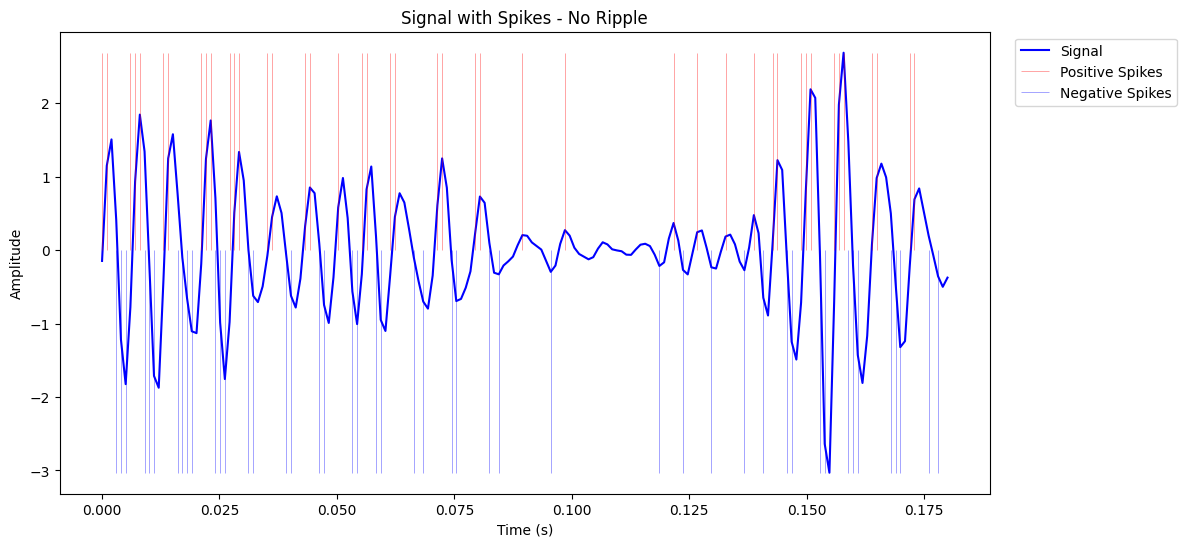

Total Spikes: 91.0
Up Spikes: 44.0
Down Spikes: 47.0


In [12]:
from snnTorch.utils.util import window_plot
window=1
plot_spikes=sorted_spikes[window,:,:]
downsample=False
if downsample:
    plot_filtered_window=average_downsampling(sorted_filtered_windows[window,:], factor)
    # plot_filtered_window=decimation_downsampling(sorted_filtered_windows[window,:], factor)
    factor1=1
else:
    plot_filtered_window=sorted_filtered_windows[window,:]
    factor1=factor
# TODO  - Check if the filtered window is correct (very weird results)

plot_gt=sorted_gt[window]
window_plot(plot_filtered_window,plot_spikes, plot_gt,downsampled_fs=1000,detection_window=RIPPLE_DETECTION_OFFSET,factor=factor1)
up_spikes_window = np.sum(plot_spikes[:, 0])    # Sum along time axis
down_spikes_window = np.sum(plot_spikes[:, 1])  # Sum along time axis
print("Total Spikes:",up_spikes_window+down_spikes_window)
print("Up Spikes:",sorted_up_spikes_per_window[window])
print("Down Spikes:",sorted_down_spikes_per_window[window])

In [13]:
is_hfo = windowed_gt >= 0
hfo_windows = windowed_input_data[is_hfo]       # shape: (N_HFO, 180, 2)
non_hfo_windows = windowed_input_data[~is_hfo]  # shape: (N_nonHFO, 180, 2)
windowed_gt_hfo = windowed_gt[is_hfo]       # shape: (N_HFO, 180, 2)
windowed_gt_non_hfo = windowed_gt[~is_hfo]  # shape: (N_nonHFO, 180, 2) 

In [14]:
# Sum over time axis
hfo_up_counts = np.sum(hfo_windows[:, :, 0], axis=1)
hfo_down_counts = np.sum(hfo_windows[:, :, 1], axis=1)
og_total_hfo_counts= hfo_up_counts + hfo_down_counts
nonhfo_up_counts = np.sum(non_hfo_windows[:, :, 0], axis=1)
nonhfo_down_counts= np.sum(non_hfo_windows[:, :,1], axis=1)
og_total_nonhfo_counts = nonhfo_up_counts + nonhfo_down_counts
average_total_counts= (np.sum(og_total_hfo_counts)+np.sum(og_total_nonhfo_counts))/len(windowed_input_data)

# Print the average counts
average_hfo_up_counts = np.mean(hfo_up_counts)
average_hfo_down_counts = np.mean(hfo_down_counts)
average_total_hfo_counts = np.mean(og_total_hfo_counts)
average_nonhfo_up_counts = np.mean(nonhfo_up_counts)
average_nonhfo_down_counts = np.mean(nonhfo_down_counts)
average_total_nonhfo_counts = np.mean(og_total_nonhfo_counts)
print(f"Average HFO Up Counts: {average_hfo_up_counts}")
print(f"Average HFO Down Counts: {average_hfo_down_counts}")
print(f"Average Total HFO Counts: {average_total_hfo_counts}")
print(f"Average Non-HFO Up Counts: {average_nonhfo_up_counts}")
print(f"Average Non-HFO Down Counts: {average_nonhfo_down_counts}")
print(f"Average Total Non-HFO Counts: {average_total_nonhfo_counts}")
print(f"Average Total Counts: {average_total_counts}")


Average HFO Up Counts: 10.144717000100533
Average HFO Down Counts: 10.357243389966824
Average Total HFO Counts: 20.501960390067357
Average Non-HFO Up Counts: 4.244659068482337
Average Non-HFO Down Counts: 4.2768650088809945
Average Total Non-HFO Counts: 8.521524077363331
Average Total Counts: 9.830804557290236


In [15]:
def get_isi(spike_train):
    times_up = np.where(spike_train[:,0])[0]  # spike times (e.g., indices)
    times_down = np.where(spike_train[:,0])[0]  # spike times (e.g., indices)
    times_total= np.concatenate((times_up, times_down))
    times_total.sort()  # sort the spike times
    if len(times_total) < 2:
        return np.array([])  # no ISI to compute
    return np.diff(times_total)

# Example for all HFO windows (up channel):
hfo_up_isis = [get_isi(window[:, :]) for window in hfo_windows]
nonhfo_up_isis = [get_isi(window[:, :]) for window in non_hfo_windows]

hfo_up_isi_mean = np.array([np.mean(isi) if len(isi) > 0 else 0 for isi in hfo_up_isis])
nonhfo_up_isi_mean = np.array([np.mean(isi) if len(isi) > 0 else 0 for isi in nonhfo_up_isis])


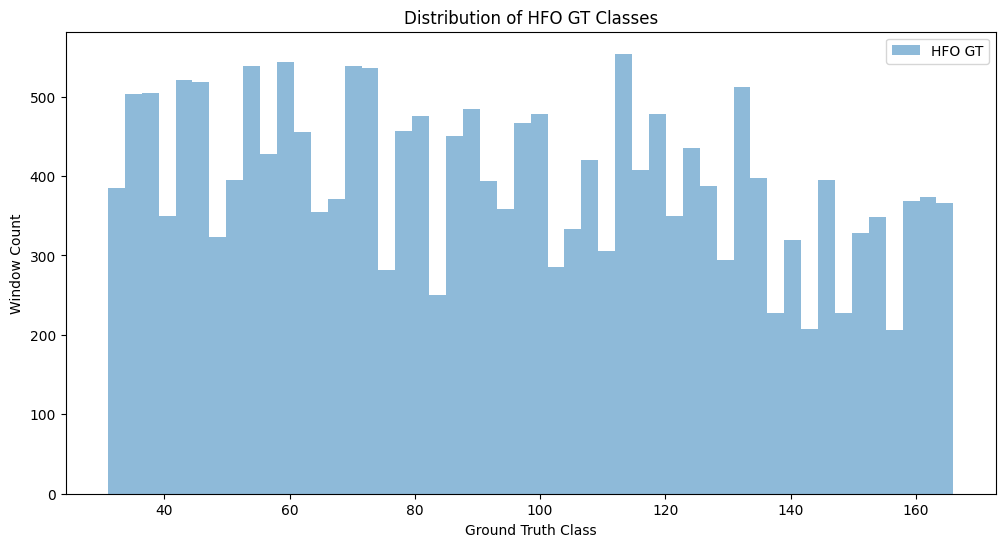

In [16]:
plt.subplots(figsize=(12, 6))
plt.hist(windowed_gt_hfo, bins=50, alpha=0.5, label='HFO GT')
plt.legend()
plt.title('Distribution of HFO GT Classes')
plt.xlabel('Ground Truth Class')
plt.ylabel('Window Count')
plt.show()

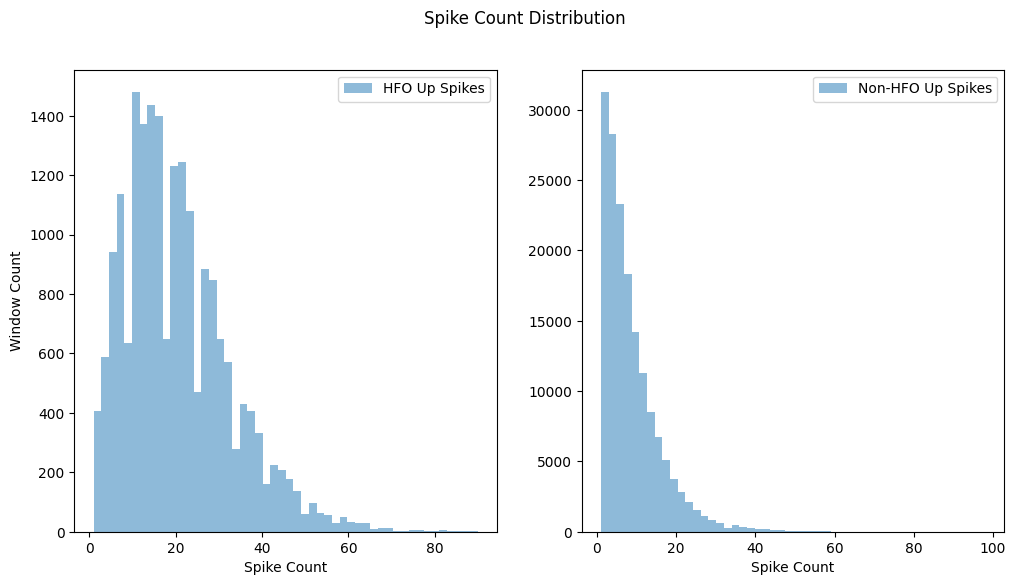

In [17]:
plt.subplots(1,2, figsize=(12, 6))
plt.suptitle('Spike Count Distribution')
plt.subplot(1, 2, 1)
plt.hist(og_total_hfo_counts,bins=50, alpha=0.5, label='HFO Up Spikes')
plt.xlabel('Spike Count')
plt.ylabel('Window Count')
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(og_total_nonhfo_counts, bins=50, alpha=0.5, label='Non-HFO Up Spikes')
plt.legend()
plt.xlabel('Spike Count')
plt.show()

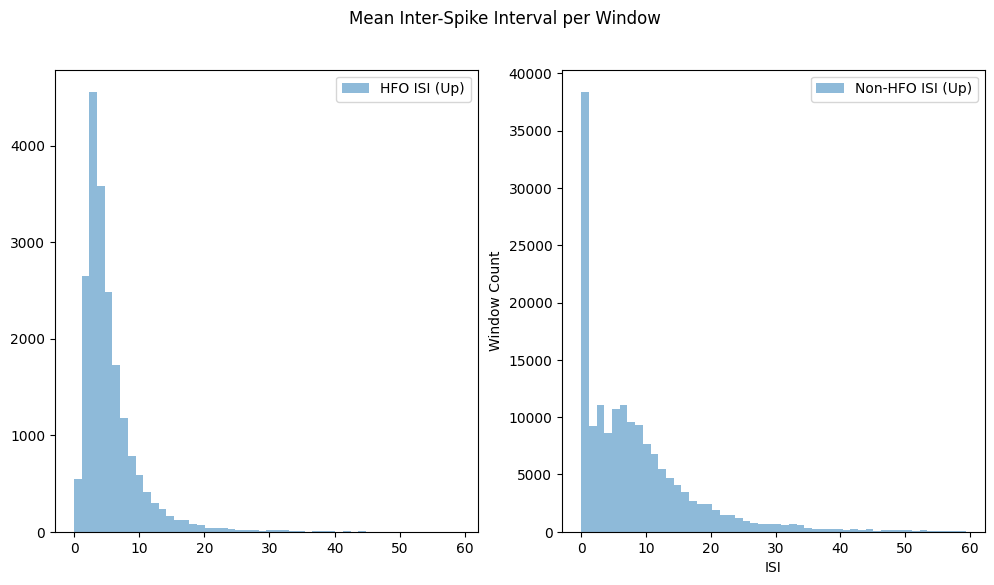

In [18]:
plt.subplots(1,2, figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(hfo_up_isi_mean, bins=50, alpha=0.5, label='HFO ISI (Up)')
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(nonhfo_up_isi_mean, bins=50, alpha=0.5, label='Non-HFO ISI (Up)')
plt.legend()
plt.suptitle('Mean Inter-Spike Interval per Window')
plt.xlabel('ISI')
plt.ylabel('Window Count')
plt.show()

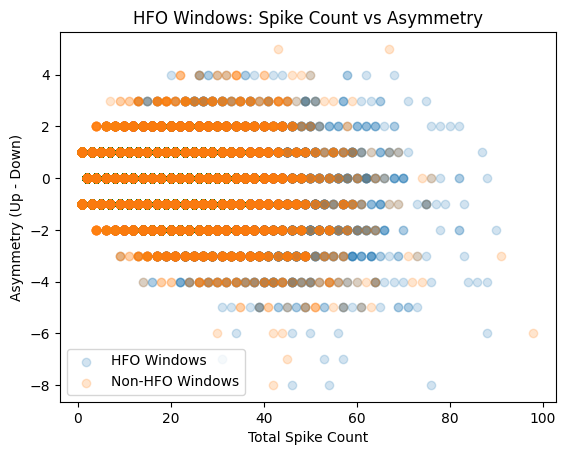

In [19]:
# Evaluate HFO windows
asymmetry_hfos = (hfo_up_counts - hfo_down_counts)
asymmetry_nonhfos = nonhfo_up_counts - nonhfo_down_counts

plt.scatter(og_total_hfo_counts,asymmetry_hfos , alpha=0.2, label='HFO Windows')
plt.scatter(og_total_nonhfo_counts,asymmetry_nonhfos, alpha=0.2, label='Non-HFO Windows')
plt.xlabel('Total Spike Count')
plt.ylabel('Asymmetry (Up - Down)')
plt.title('HFO Windows: Spike Count vs Asymmetry')
plt.legend()
plt.show()

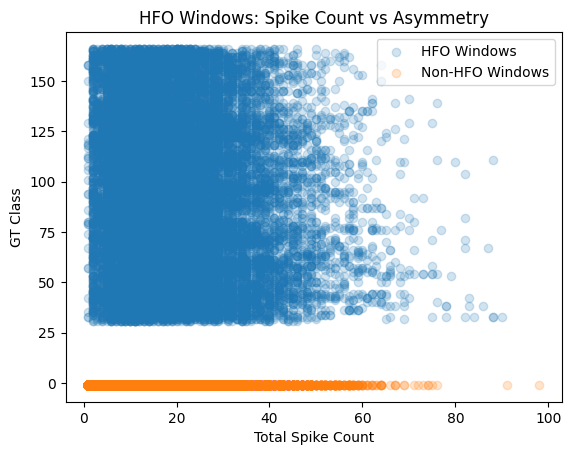

In [20]:
plt.scatter(og_total_hfo_counts,windowed_gt_hfo, alpha=0.2, label='HFO Windows')
plt.scatter(og_total_nonhfo_counts,windowed_gt_non_hfo, alpha=0.2, label='Non-HFO Windows')
plt.xlabel('Total Spike Count')
plt.ylabel('GT Class')
plt.title('HFO Windows: Spike Count vs Asymmetry')
plt.legend()
plt.show()

## Process Windows

In [21]:
p1_windowed_input_data,p1_windowed_gt,p1_ripple_ids=only_some_channels_per_ripple(windowed_input_data,windowed_gt,ripple_ids,1)


In [22]:
# See GT Class Distribution
# Set print options to see more elements
np.set_printoptions(linewidth=100, threshold=50, edgeitems=20)
print(f"Ground Truth Class Distribution: {np.unique(p1_windowed_gt, return_counts=True)}")



GT_HFO_MASK = p1_windowed_gt >= 0
# print(windowed_gt[0:1000])
# Define the number of windows with an HFO
num_hfo_windows = np.sum(GT_HFO_MASK)
print(f"Number of windows with an HFO: {num_hfo_windows}")
print(f"Percentage of windows with an HFO: {num_hfo_windows / p1_windowed_gt.shape[0] * 100:.2f}%")



Ground Truth Class Distribution: (array([ -1.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49., ..., 147., 148., 149., 150., 151., 152., 153., 154., 155.,
       156., 157., 158., 159., 160., 161., 162., 163., 164., 165., 166.], dtype=float32), array([162144,      8,     13,      9,     14,     17,     11,     17,     14,     15,     17,
           11,     20,     18,     14,     19,     15,     18,     21,     20, ...,     13,     16,
           13,     17,      5,      6,      9,      5,     10,      7,      3,      7,      8,
            8,      9,      5,      5,      5,      6,      9], dtype=int64))
Number of windows with an HFO: 2326
Percentage of windows with an HFO: 1.41%


In [23]:
# Find the indices to sort the input data by the nº of UP/DN spikes (descending order)
sorted_indices = np.argsort(
    -(np.sum(p1_windowed_input_data[:, :, 0], axis=1) + np.sum(p1_windowed_input_data[:, :, 1], axis=1)), 
)
sorted_spikes = p1_windowed_input_data[sorted_indices]
sorted_gt= p1_windowed_gt[sorted_indices]
sorted_ripples=p1_ripple_ids[sorted_indices]
sorted_up_spikes_per_window = np.sum(sorted_spikes[:, :, 0], axis=1)    # Sum along time axis
sorted_down_spikes_per_window = np.sum(sorted_spikes[:, :, 1], axis=1)  # Sum along time axis
print(f"sorted_indices: {sorted_indices}")
print(f"Sorted_data: {sorted_spikes.shape} | Sorted_gt: {sorted_gt.shape}")
print(f"Sorted_gt preview: {sorted_gt[:10]}")
print(f"GT first window: {sorted_gt[0]} | GT last window: {sorted_gt[-1]}")

sorted_indices: [  7927  19972 163466 162938 162855 162360 162602 163154 162713 162909 162593 163053 162606  31520
 162808 163499 162559 162905 163088  12223 ... 157379  83482  83479 111336 157365  83462 131849
  36441 131839  54526  17510  83408 111395 146826 146828 111412  54538  54547 111423  98070]
Sorted_data: (164470, 180, 2) | Sorted_gt: (164470,)
Sorted_gt preview: [ -1.  -1.  33. 111.  67.  38.  42.  82.  71. 104.]
GT first window: -1.0 | GT last window: -1.0


In [24]:
sorted_gt_distribution=sorted_gt[:1000]
print(f"Sorted GT Distribution: {np.unique(sorted_gt_distribution, return_counts=True)}")

Sorted GT Distribution: (array([ -1.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49., ..., 142., 144., 145., 146., 148., 149., 150., 151., 152.,
       153., 154., 156., 157., 158., 159., 160., 162., 163., 164., 166.], dtype=float32), array([589,   2,   5,   4,   4,   3,   4,   3,   1,   5,   4,   2,   5,   4,   6,   4,   1,   5,
         5,   5, ...,   1,   1,   4,   2,   1,   2,   2,   1,   1,   2,   1,   1,   1,   3,   1,
         2,   1,   1,   1,   1], dtype=int64))


In [25]:
is_hfo = p1_windowed_gt >= 0
hfo_windows = p1_windowed_input_data[is_hfo]       # shape: (N_HFO, 180, 2)
non_hfo_windows = p1_windowed_input_data[~is_hfo]  # shape: (N_nonHFO, 180, 2)
windowed_gt_hfo = p1_windowed_gt[is_hfo]       # shape: (N_HFO, 180, 2)
windowed_gt_non_hfo = p1_windowed_gt[~is_hfo]  # shape: (N_nonHFO, 180, 2)

In [26]:
# Sum over time axis
hfo_up_counts = np.sum(hfo_windows[:, :, 0], axis=1)
hfo_down_counts = np.sum(hfo_windows[:, :, 1], axis=1)
total_hfo_counts= hfo_up_counts + hfo_down_counts
nonhfo_up_counts = np.sum(non_hfo_windows[:, :, 0], axis=1)
nonhfo_down_counts= np.sum(non_hfo_windows[:, :,1], axis=1)
total_nonhfo_counts = nonhfo_up_counts + nonhfo_down_counts

average_hfo_up_counts = np.mean(hfo_up_counts)
average_hfo_down_counts = np.mean(hfo_down_counts)
average_total_hfo_counts = np.mean(total_hfo_counts)
average_nonhfo_up_counts = np.mean(nonhfo_up_counts)
average_nonhfo_down_counts = np.mean(nonhfo_down_counts)
average_total_nonhfo_counts = np.mean(total_nonhfo_counts)
average_total_counts= (np.sum(total_hfo_counts)+np.sum(total_nonhfo_counts))/len(p1_windowed_input_data)

print(f"Average HFO Up Counts: {average_hfo_up_counts}")
print(f"Average HFO Down Counts: {average_hfo_down_counts}")
print(f"Average Total HFO Counts: {average_total_hfo_counts}")
print(f"Average Non-HFO Up Counts: {average_nonhfo_up_counts}")
print(f"Average Non-HFO Down Counts: {average_nonhfo_down_counts}")
print(f"Average Total Non-HFO Counts: {average_total_nonhfo_counts}")
print(f"Average Total Counts: {average_total_counts}")

Average HFO Up Counts: 14.63585554600172
Average HFO Down Counts: 15.040412725709372
Average Total HFO Counts: 29.67626827171109
Average Non-HFO Up Counts: 4.244659068482337
Average Non-HFO Down Counts: 4.2768650088809945
Average Total Non-HFO Counts: 8.521524077363331
Average Total Counts: 8.820702863744147


In [27]:
# Example for all HFO windows (up channel):
hfo_up_isis = [get_isi(window[:, :]) for window in hfo_windows]
nonhfo_up_isis = [get_isi(window[:, :]) for window in non_hfo_windows]

hfo_up_isi_mean = np.array([np.mean(isi) if len(isi) > 0 else 0 for isi in hfo_up_isis])
nonhfo_up_isi_mean = np.array([np.mean(isi) if len(isi) > 0 else 0 for isi in nonhfo_up_isis])


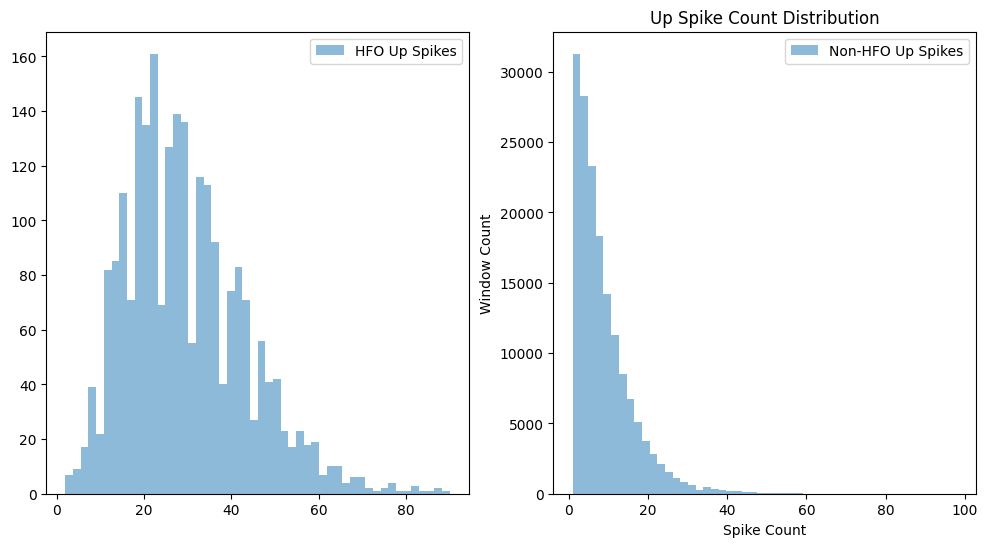

In [28]:
plt.subplots(1,2, figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(total_hfo_counts,bins=50, alpha=0.5, label='HFO Up Spikes')
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(total_nonhfo_counts, bins=50, alpha=0.5, label='Non-HFO Up Spikes')
plt.legend()
plt.title('Up Spike Count Distribution')
plt.xlabel('Spike Count')
plt.ylabel('Window Count')
plt.show()

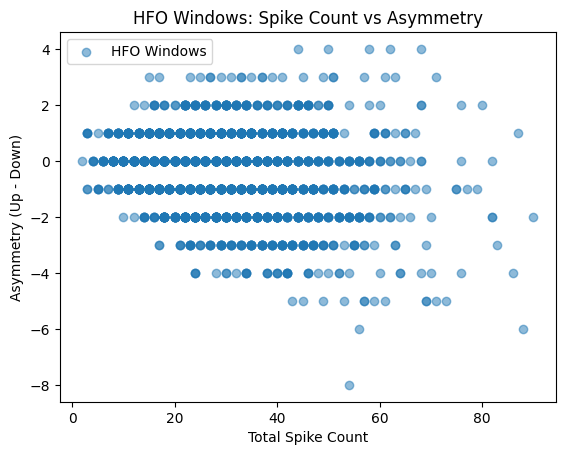

In [29]:
# Evaluate HFO windows
asymmetry_hfos = (hfo_up_counts - hfo_down_counts)
asymmetry_nonhfos = nonhfo_up_counts - nonhfo_down_counts

plt.scatter(total_hfo_counts,asymmetry_hfos , alpha=0.5, label='HFO Windows')
# plt.scatter(total_nonhfo_counts,asymmetry_nonhfos, alpha=0.5, label='Non-HFO Windows')
plt.xlabel('Total Spike Count')
plt.ylabel('Asymmetry (Up - Down)')
plt.title('HFO Windows: Spike Count vs Asymmetry')
plt.legend()
plt.show()

## Process - Remove Windows above thresholds

In [30]:
# print(average_total_hfo_counts)
# thresholds=[average_total_counts,average_total_hfo_counts*20]


nonhfo_threshold = np.percentile(og_total_nonhfo_counts, 90) 
hfo_activity_threshold = np.percentile(og_total_hfo_counts, 50) 
thresholds = [nonhfo_threshold, hfo_activity_threshold]

# thresholds=[100,50]
# p2_windowed_input_data,p2_windowed_gt,p2_ripple_ids=min_max_spike_threshold(p1_windowed_input_data,p1_windowed_gt,
#                                                                          p1_ripple_ids,MEAN_DETECTION_OFFSET,thresholds)

p2_windowed_input_data,p2_windowed_gt,p2_ripple_ids=min_max_spike_threshold_prob(windowed_input_data,windowed_gt,
                                                                         ripple_ids,MEAN_DETECTION_OFFSET,thresholds,max_prob=0.9,multiplier=2,decay=3,drop_fn=drop_exponential)

False Positive Removed (Prob 0.81) - Spikes: 4.0
False Negative Removed (Prob 0.73) - Spikes: 28.0
False Negative Removed (Prob 0.14) - Spikes: 19.0
False Negative Removed (Prob 0.44) - Spikes: 22.0
False Negative Removed (Prob 0.76) - Spikes: 29.0
False Positive Removed (Prob 0.44) - Spikes: 14.0
False Negative Removed (Prob 0.88) - Spikes: 40.0
False Negative Removed (Prob 0.73) - Spikes: 28.0
False Negative Removed (Prob 0.70) - Spikes: 27.0
False Negative Removed (Prob 0.78) - Spikes: 30.0
False Negative Removed (Prob 0.80) - Spikes: 31.0
False Negative Removed (Prob 0.88) - Spikes: 41.0
False Negative Removed (Prob 0.51) - Spikes: 23.0
False Negative Removed (Prob 0.66) - Spikes: 26.0
False Negative Removed (Prob 0.44) - Spikes: 22.0
False Negative Removed (Prob 0.14) - Spikes: 19.0
False Negative Removed (Prob 0.80) - Spikes: 31.0
False Negative Removed (Prob 0.76) - Spikes: 29.0
False Negative Removed (Prob 0.57) - Spikes: 24.0
False Negative Removed (Prob 0.90) - Spikes: 66.0
F

In [31]:
# See GT Class Distribution
# Set print options to see more elements
np.set_printoptions(linewidth=100, threshold=50, edgeitems=20)
print(f"Ground Truth Class Distribution: {np.unique(p2_windowed_gt, return_counts=True)}")



GT_HFO_MASK = p2_windowed_gt >= 0
# print(windowed_gt[0:1000])
# Define the number of windows with an HFO
num_hfo_windows = np.sum(GT_HFO_MASK)
print(f"Number of windows with an HFO: {num_hfo_windows}")
print(f"Percentage of windows with an HFO: {num_hfo_windows / p2_windowed_gt.shape[0] * 100:.2f}%")

Ground Truth Class Distribution: (array([ -1.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49., ..., 147., 148., 149., 150., 151., 152., 153., 154., 155.,
       156., 157., 158., 159., 160., 161., 162., 163., 164., 165., 166.], dtype=float32), array([154230,     70,    109,     99,    124,    151,    107,    127,    133,    144,    144,
           92,    144,    130,    119,    146,    138,    109,    126,    127, ...,     79,     89,
           73,     70,     52,     77,     74,     60,     93,     95,     74,     79,     84,
           88,     60,     98,     79,     92,     75,    103], dtype=int64))
Number of windows with an HFO: 14537
Percentage of windows with an HFO: 8.61%


In [32]:
# Find the indices to sort the input data by the nº of UP/DN spikes (descending order)
sorted_indices = np.argsort(
    -(np.sum(p2_windowed_input_data[:, :, 0], axis=1) + np.sum(p2_windowed_input_data[:, :, 1], axis=1)), 
)
sorted_spikes = p2_windowed_input_data[sorted_indices]
sorted_gt= p2_windowed_gt[sorted_indices]
sorted_ripples=p2_ripple_ids[sorted_indices]
sorted_up_spikes_per_window = np.sum(sorted_spikes[:, :, 0], axis=1)    # Sum along time axis
sorted_down_spikes_per_window = np.sum(sorted_spikes[:, :, 1], axis=1)  # Sum along time axis
print(f"sorted_indices: {sorted_indices}")
print(f"Sorted_data: {sorted_spikes.shape} | Sorted_gt: {sorted_gt.shape}")
print(f"Sorted_gt preview: {sorted_gt[:10]}")
print(f"GT first window: {sorted_gt[0]} | GT last window: {sorted_gt[-1]}")

sorted_indices: [118233 122874 127115   7992   7389   2109 113626  25180   5797   7691  18810   6400  11379 131468
   5752   9584  43432  13493 135833   5805 ... 102853  54330 148767 148768  25924 157826  54325
 136597 148775  43644  80406  43645  43646  43647  43654 136580 163370  43655  80396  36009]
Sorted_data: (168767, 180, 2) | Sorted_gt: (168767,)
Sorted_gt preview: [ 33.  33.  33. 111.  67.  38.  33.  38.  42. 104.]
GT first window: 33.0 | GT last window: -1.0


In [33]:
sorted_gt_distribution=sorted_gt[:1000]
sorted_ripple_distribution=sorted_ripples[:1000]

print(f"Sorted GT Distribution: {np.unique(sorted_gt_distribution, return_counts=True)}")
print(f"Sorted Ripple Distribution: {np.unique(sorted_ripple_distribution, return_counts=True)}")


Sorted GT Distribution: (array([ -1.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49., ..., 141., 142., 144., 145., 146., 149., 150., 151., 152.,
       153., 154., 156., 157., 158., 159., 160., 162., 163., 164., 166.], dtype=float32), array([49,  3,  5, 15,  9,  1, 17,  6,  8, 10, 12,  7, 22, 18, 25,  8,  2,  9,  4,  9, ...,  2,  1,
        4,  4,  4,  2,  6,  1,  1,  8,  6,  2,  2,  9,  2,  5,  2,  4,  4,  2], dtype=int64))
Sorted Ripple Distribution: (array([  -1,    3,   13,   19,   25,   36,   38,   48,   53,   55,   68,   69,   80,   86,  103,
        105,  107,  110,  112,  116, ..., 1937, 1997, 2011, 2219, 2266, 2276, 2366, 2419, 2420,
       2429, 2452, 2471, 2483, 2501, 2503, 2519, 2536, 2558, 2566, 2597]), array([49,  1,  1,  2,  3,  2,  3,  2,  2,  3,  3,  6,  2,  4, 11,  1,  3,  4,  5,  5, ...,  1,  6,
        3,  1,  1,  3,  5,  5,  2,  1,  2,  5,  2,  1,  4,  1,  3,  3,  6,  1], dtype=int64))


In [34]:
is_hfo = p2_windowed_gt >= 0
hfo_windows = p2_windowed_input_data[is_hfo]       # shape: (N_HFO, 180, 2)
non_hfo_windows = p2_windowed_input_data[~is_hfo]  # shape: (N_nonHFO, 180, 2)
windowed_gt_hfo = p2_windowed_gt[is_hfo]       # shape: (N_HFO, 180, 2)
windowed_gt_non_hfo = p2_windowed_gt[~is_hfo]  # shape: (N_nonHFO, 180, 2)

In [35]:
# Sum over time axis
hfo_up_counts = np.sum(hfo_windows[:, :, 0], axis=1)
hfo_down_counts = np.sum(hfo_windows[:, :, 1], axis=1)
total_hfo_counts= hfo_up_counts + hfo_down_counts
nonhfo_up_counts = np.sum(non_hfo_windows[:, :, 0], axis=1)
nonhfo_down_counts= np.sum(non_hfo_windows[:, :,1], axis=1)
total_nonhfo_counts = nonhfo_up_counts + nonhfo_down_counts

average_hfo_up_counts = np.mean(hfo_up_counts)
average_hfo_down_counts = np.mean(hfo_down_counts)
average_total_hfo_counts = np.mean(total_hfo_counts)
average_nonhfo_up_counts = np.mean(nonhfo_up_counts)
average_nonhfo_down_counts = np.mean(nonhfo_down_counts)
average_total_nonhfo_counts = np.mean(total_nonhfo_counts)
average_total_counts= (np.sum(total_hfo_counts)+np.sum(total_nonhfo_counts))/len(p2_windowed_input_data)
print(f"Average HFO Up Counts: {average_hfo_up_counts}")
print(f"Average HFO Down Counts: {average_hfo_down_counts}")
print(f"Average Total HFO Counts: {average_total_hfo_counts}")
print(f"Average Non-HFO Up Counts: {average_nonhfo_up_counts}")
print(f"Average Non-HFO Down Counts: {average_nonhfo_down_counts}")
print(f"Average Total Non-HFO Counts: {average_total_nonhfo_counts}")
print(f"Average Total Counts: {average_total_counts}")
print(f"Number of windows with an HFO: {num_hfo_windows}")
print(f"Number of windows without an HFO:", len(p2_windowed_input_data)-num_hfo_windows)

Average HFO Up Counts: 12.224117768452913
Average HFO Down Counts: 12.50244204443833
Average Total HFO Counts: 24.726559812891242
Average Non-HFO Up Counts: 3.73865006808014
Average Non-HFO Down Counts: 3.7612850936912405
Average Total Non-HFO Counts: 7.49993516177138
Average Total Counts: 8.98377644918734
Number of windows with an HFO: 14537
Number of windows without an HFO: 154230


In [36]:
# Example for all HFO windows (up channel):
hfo_up_isis = [get_isi(window[:, :]) for window in hfo_windows]
nonhfo_up_isis = [get_isi(window[:, :]) for window in non_hfo_windows]

hfo_up_isi_mean = np.array([np.mean(isi) if len(isi) > 0 else 0 for isi in hfo_up_isis])
nonhfo_up_isi_mean = np.array([np.mean(isi) if len(isi) > 0 else 0 for isi in nonhfo_up_isis])

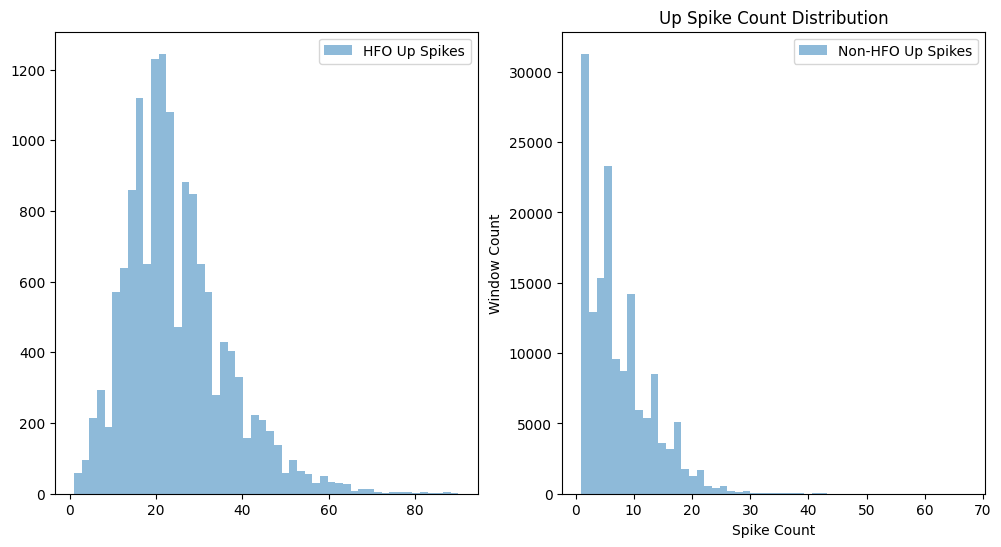

In [37]:
plt.subplots(1,2, figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(total_hfo_counts,bins=50, alpha=0.5, label='HFO Up Spikes')
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(total_nonhfo_counts, bins=50, alpha=0.5, label='Non-HFO Up Spikes')
plt.legend()
plt.title('Up Spike Count Distribution')
plt.xlabel('Spike Count')
plt.ylabel('Window Count')
plt.show()

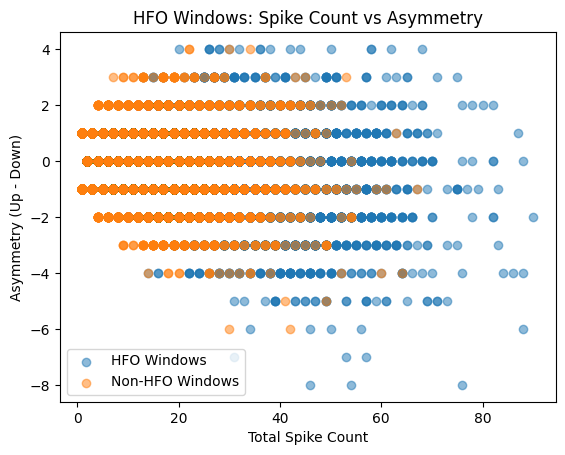

In [38]:
# Evaluate HFO windows
asymmetry_hfos = (hfo_up_counts - hfo_down_counts)
asymmetry_nonhfos = nonhfo_up_counts - nonhfo_down_counts

plt.scatter(total_hfo_counts,asymmetry_hfos , alpha=0.5, label='HFO Windows')
plt.scatter(total_nonhfo_counts,asymmetry_nonhfos, alpha=0.5, label='Non-HFO Windows')
plt.xlabel('Total Spike Count')
plt.ylabel('Asymmetry (Up - Down)')
plt.title('HFO Windows: Spike Count vs Asymmetry')
plt.legend()
plt.show()

Text(0.5, 1.0, 'HFO Windows: Spike Count vs Asymmetry')

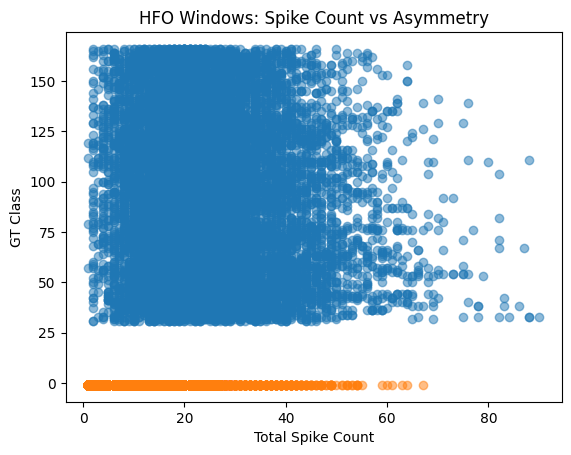

In [39]:
plt.scatter(total_hfo_counts,windowed_gt_hfo, alpha=0.5, label='HFO Windows')
plt.scatter(total_nonhfo_counts,windowed_gt_non_hfo, alpha=0.5, label='Non-HFO Windows')
plt.xlabel('Total Spike Count')
plt.ylabel('GT Class')
plt.title('HFO Windows: Spike Count vs Asymmetry')

## After Undersampling Non-Ripples

In [40]:
from snnTorch.utils.training import undersample_majority, oversample_minority
intermediate_input, intermediate_gt = windowed_input_data, windowed_gt  # Default: No Balancing
balance=True
if balance:
    intermediate_input, intermediate_gt = undersample_majority(windowed_input_data, windowed_gt)
    # intermediate_input, intermediate_gt = undersample_majority(p2_windowed_input_data, p2_windowed_gt)  

# Print the number of samples in each class
print(f"Intermediate GT Class Distribution: {np.unique(intermediate_gt, return_counts=True)}")
print(f"Intermediate Window Input Data Shape: {intermediate_input.shape}")


Intermediate GT Class Distribution: (array([ -1.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49., ..., 147., 148., 149., 150., 151., 152., 153., 154., 155.,
       156., 157., 158., 159., 160., 161., 162., 163., 164., 165., 166.], dtype=float32), array([19894,   103,   148,   134,   150,   209,   144,   158,   163,   183,   197,   153,   193,
         179,   149,   187,   189,   142,   167,   156, ...,   101,   126,   102,   130,    83,
         115,   104,    86,   159,   112,    94,   124,   104,   140,   116,   137,   121,   110,
         107,   149], dtype=int64))
Intermediate Window Input Data Shape: (39788, 180, 2)


In [41]:
is_hfo= intermediate_gt >= 0
hfo_windows = intermediate_input[is_hfo]       # shape: (N_HFO, 180, 2)
non_hfo_windows = intermediate_input[~is_hfo]  # shape: (N_nonHFO, 180, 2)
windowed_gt_hfo = intermediate_gt[is_hfo]       # shape: (N_HFO, 180, 2)
windowed_gt_non_hfo = intermediate_gt[~is_hfo]  # shape: (N_nonHFO, 180, 2)
print(f"Number of HFO windows: {hfo_windows.shape[0]}")
print(f"Number of Non-HFO windows: {non_hfo_windows.shape[0]}")

Number of HFO windows: 19894
Number of Non-HFO windows: 19894


In [42]:
# Sum over time axis
hfo_up_counts = np.sum(hfo_windows[:, :, 0], axis=1)
hfo_down_counts = np.sum(hfo_windows[:, :, 1], axis=1)
total_hfo_counts= hfo_up_counts + hfo_down_counts
nonhfo_up_counts = np.sum(non_hfo_windows[:, :, 0], axis=1)
nonhfo_down_counts= np.sum(non_hfo_windows[:, :,1], axis=1)
total_nonhfo_counts = nonhfo_up_counts + nonhfo_down_counts

average_hfo_up_counts = np.mean(hfo_up_counts)
average_hfo_down_counts = np.mean(hfo_down_counts)
average_total_hfo_counts = np.mean(total_hfo_counts)
average_nonhfo_up_counts = np.mean(nonhfo_up_counts)
average_nonhfo_down_counts = np.mean(nonhfo_down_counts)
average_total_nonhfo_counts = np.mean(total_nonhfo_counts)
average_total_counts= (np.sum(total_hfo_counts)+np.sum(total_nonhfo_counts))/len(intermediate_input)

print(f"Average HFO Up Counts: {average_hfo_up_counts}")
print(f"Average HFO Down Counts: {average_hfo_down_counts}")
print(f"Average Total HFO Counts: {average_total_hfo_counts}")
print(f"Average Non-HFO Up Counts: {average_nonhfo_up_counts}")
print(f"Average Non-HFO Down Counts: {average_nonhfo_down_counts}")
print(f"Average Total Non-HFO Counts: {average_total_nonhfo_counts}")
print(f"Average Total Counts: {average_total_counts}")

# Example for all HFO windows (up channel):
hfo_up_isis = [get_isi(window[:, :]) for window in hfo_windows]
nonhfo_up_isis = [get_isi(window[:, :]) for window in non_hfo_windows]

hfo_up_isi_mean = np.array([np.mean(isi) if len(isi) > 0 else 0 for isi in hfo_up_isis])
nonhfo_up_isi_mean = np.array([np.mean(isi) if len(isi) > 0 else 0 for isi in nonhfo_up_isis])


Average HFO Up Counts: 10.144717000100533
Average HFO Down Counts: 10.357243389966824
Average Total HFO Counts: 20.501960390067357
Average Non-HFO Up Counts: 4.3141650748969536
Average Non-HFO Down Counts: 4.348446767869709
Average Total Non-HFO Counts: 8.662611842766664
Average Total Counts: 14.582286116417011


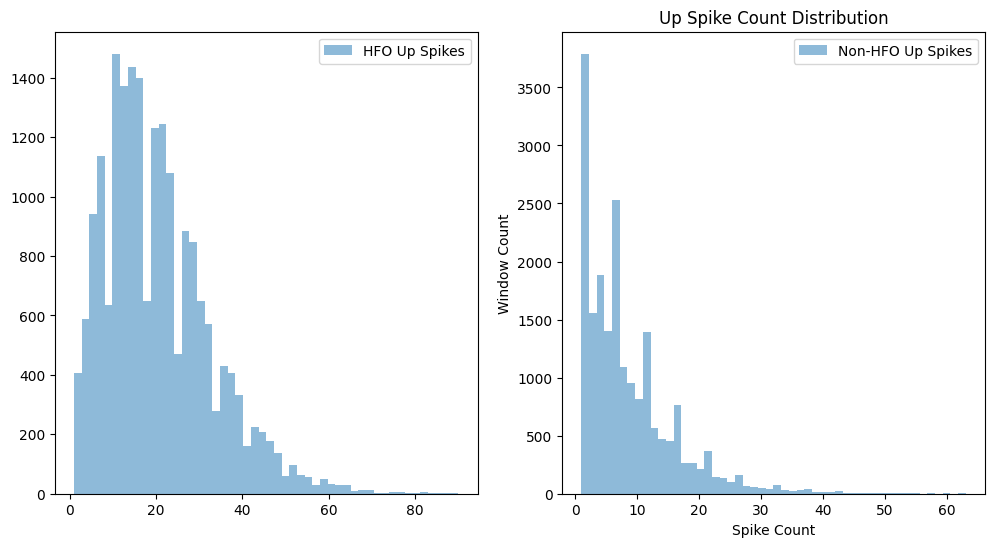

In [43]:
plt.subplots(1,2, figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(total_hfo_counts,bins=50, alpha=0.5, label='HFO Up Spikes')
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(total_nonhfo_counts, bins=50, alpha=0.5, label='Non-HFO Up Spikes')
plt.legend()
plt.title('Up Spike Count Distribution')
plt.xlabel('Spike Count')
plt.ylabel('Window Count')
plt.show()

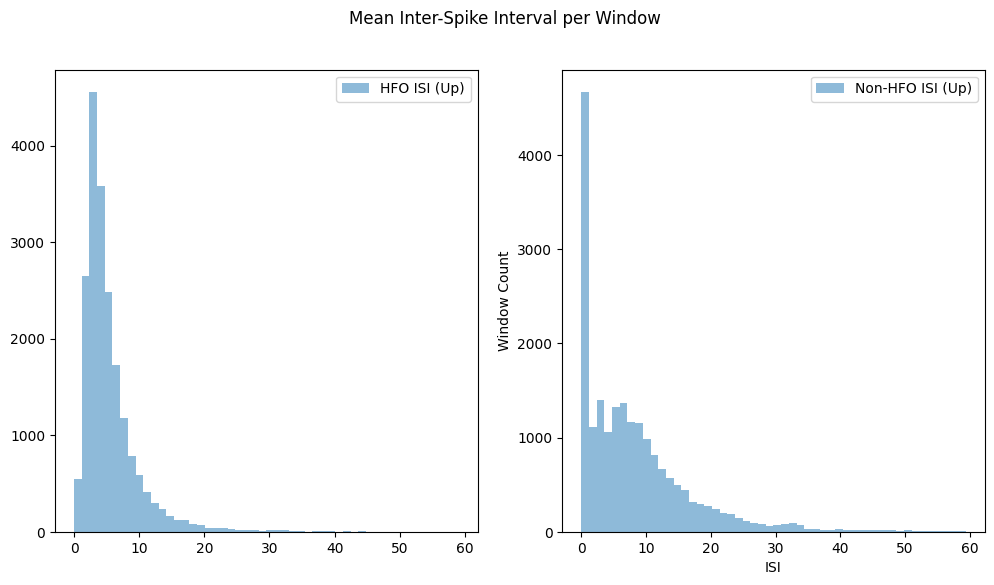

In [44]:
plt.subplots(1,2, figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(hfo_up_isi_mean, bins=50, alpha=0.5, label='HFO ISI (Up)')
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(nonhfo_up_isi_mean, bins=50, alpha=0.5, label='Non-HFO ISI (Up)')
plt.legend()
plt.suptitle('Mean Inter-Spike Interval per Window')
plt.xlabel('ISI')
plt.ylabel('Window Count')
plt.show()

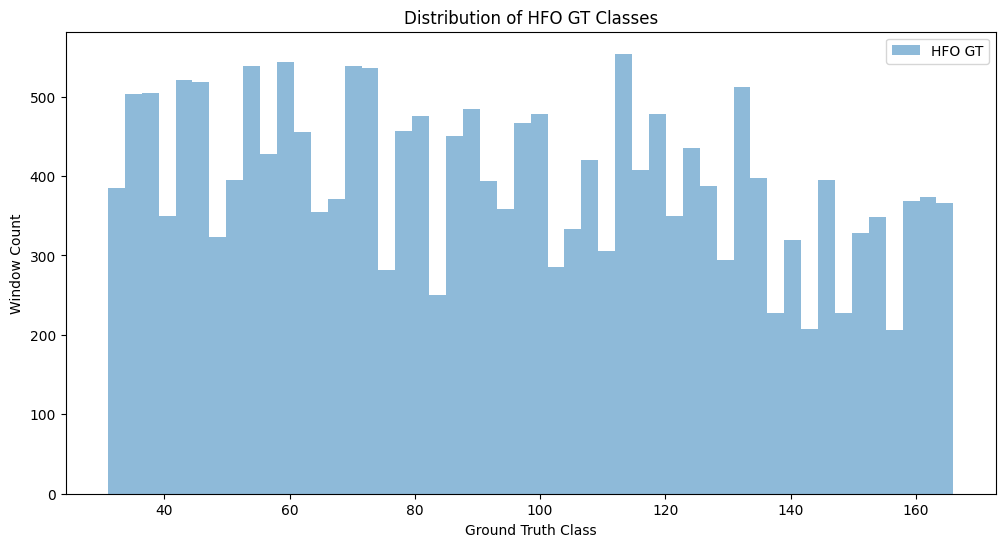

In [45]:
plt.subplots(figsize=(12, 6))
plt.hist(windowed_gt_hfo, bins=50, alpha=0.5, label='HFO GT')
plt.legend()
plt.title('Distribution of HFO GT Classes')
plt.xlabel('Ground Truth Class')
plt.ylabel('Window Count')
plt.show()

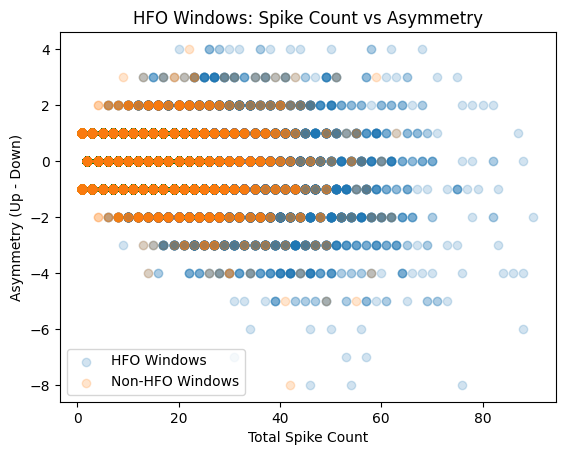

In [46]:
# Evaluate HFO windows
asymmetry_hfos = (hfo_up_counts - hfo_down_counts)
asymmetry_nonhfos = nonhfo_up_counts - nonhfo_down_counts

plt.scatter(total_hfo_counts,asymmetry_hfos , alpha=0.2, label='HFO Windows')
plt.scatter(total_nonhfo_counts,asymmetry_nonhfos, alpha=0.2, label='Non-HFO Windows')
plt.xlabel('Total Spike Count')
plt.ylabel('Asymmetry (Up - Down)')
plt.title('HFO Windows: Spike Count vs Asymmetry')
plt.legend()
plt.show()

Text(0.5, 1.0, 'HFO Windows: Spike Count vs GT Class')

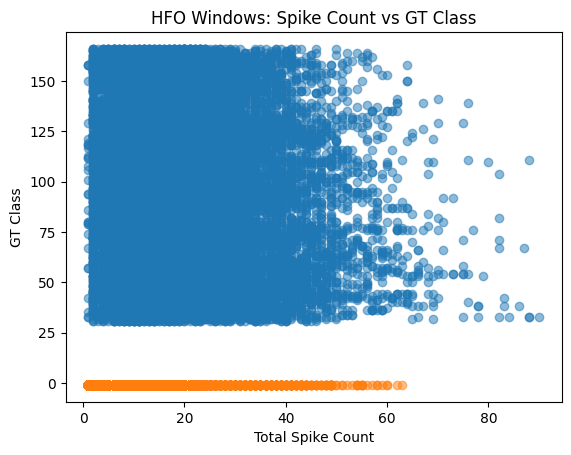

In [47]:
plt.scatter(total_hfo_counts,windowed_gt_hfo, alpha=0.5, label='HFO Windows')
plt.scatter(total_nonhfo_counts,windowed_gt_non_hfo, alpha=0.5, label='Non-HFO Windows')
plt.xlabel('Total Spike Count')
plt.ylabel('GT Class')
plt.title('HFO Windows: Spike Count vs GT Class')

In [48]:
# Save the windowed 
# input data and ground truth to a file
save=False
if save:
    windowed_save=os.path.join(curr_dir,"windowed_data")
    os.makedirs(windowed_save, exist_ok=True)
    np.save(os.path.join(windowed_save, "filtered_windows.npy"), filtered_windows, allow_pickle=True)
    np.save(os.path.join(windowed_save, "windowed_input_data.npy"), windowed_input_data, allow_pickle=True)
    np.save(os.path.join(windowed_save,"windowed_gt.npy"), windowed_gt, allow_pickle=True)
    # Save the configuration to a JSON file
    with open(os.path.join(windowed_save, "config.json"), 'w') as f:
        json.dump(config, f, indent=4)